# Outlier Detection

In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time 
from sklearn.datasets import load_boston
from matplotlib import cm
import seaborn as sns
from scipy import stats

In [2]:
boston_dataset = load_boston()

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Californ

In [3]:
dataFrame = pd.DataFrame(boston_dataset.data, columns = boston_dataset.feature_names)

In [4]:
dataFrame['MEDV'] = boston_dataset.target

In [5]:
dataFrame

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


## Check for NaN values

In [6]:
dataFrame.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Select the input and output variables

In [7]:
input_feature = 'RM'
target = 'MEDV'

# Percentiles summary

| <center>Symbol | <center>Names | <center>Definition |
| --- | --- | --- |
| $Q_1$ | first quartile, lower quartile, $25th$ percentile | splits off the lowest $25%$ of data from the highest $75%$ |
| $Q_2$ | second quartile, median, $50th$ percentile | cuts data set in half |
| $Q_3$ | third quartile, upper quartile, $75th$ percentile | splits off the highest $25%$ of data from the lowest $75%$ |

# Interquartile range(IQR-score)

$$\large IQR = Q_{3} - Q_{1} $$
IQR è una sorta di misura di "dispersione" dei dati

$$\large x < {Q_1 - 1.5 * IQR}$$

$$\large x > {Q_3 + 1.5 * IQR}$$

In [8]:
dataFrame.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [9]:
Q1 = dataFrame.quantile(0.25)

In [10]:
Q2 = dataFrame.quantile(0.5)

In [11]:
Q3 = dataFrame.quantile(0.75)

In [12]:
IQR = Q3 - Q1

In [13]:
dataFrame[dataFrame < (Q1 - 1.5*IQR)][input_feature].isnull().sum()
#498 sono in-lier

498

In [14]:
print(dataFrame[~(dataFrame < (Q1 - 1.5*IQR))][input_feature].isnull().sum())
#8 sono out-lier dal basso
print(dataFrame[~(dataFrame > (Q3 + 1.5*IQR))][input_feature].isnull().sum())
#22 sono out-lier dall'alto


8
22


In [15]:
outliers_Q1 = dataFrame[~(dataFrame < (Q1 - 1.5*IQR))][input_feature]
outliers_Q3 = dataFrame[~(dataFrame > (Q3 + 1.5*IQR))][input_feature]

In [16]:
boston_IQR_outliers = dataFrame[((dataFrame < (Q1 - 1.5 * IQR)) | (dataFrame > (Q3 + 1.5 *IQR)))[input_feature]]
boston_IQR_inliers = dataFrame[~((dataFrame < (Q1 - 1.5 * IQR)) | (dataFrame > (Q3 + 1.5 *IQR)))[input_feature]]

In [17]:
print(boston_IQR_outliers.shape)
print(boston_IQR_inliers.shape)
#attento, la dimensione delle colonne è 14 perchè ci riportiam l'intera riga. Ma quello che è un oulier per una determinata 
#colonna, non lo è per un'altra feature

(30, 14)
(476, 14)


# Scatter Plot of inliers and outliers detected through the IQR method

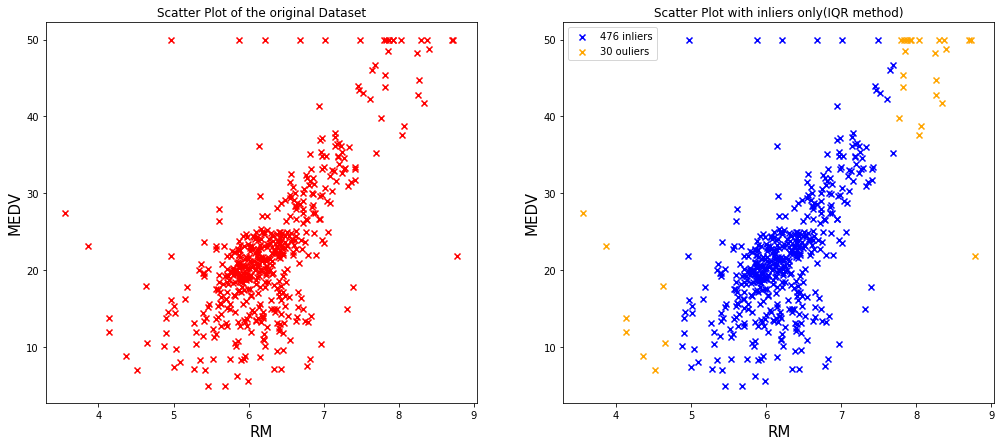

In [20]:
fig = plt.figure(figsize = (17,7))
ax1 = fig.add_subplot(121)
ax1.scatter(dataFrame[input_feature].values, dataFrame[target].values, marker = 'x', color = 'r')
ax1.set_xlabel(input_feature, fontsize= 15)
ax1.set_ylabel(target, fontsize= 15)
ax1.set_title('Scatter Plot of the original Dataset')

ax2 = fig.add_subplot(122)
ax2.scatter(boston_IQR_inliers[input_feature], boston_IQR_inliers[target], marker = 'x', color = 'blue', label = '{} inliers'.format(boston_IQR_inliers.shape[0]))
ax2.scatter(boston_IQR_outliers[input_feature], boston_IQR_outliers[target], marker = 'x', color = 'orange', label = '{} ouliers'.format(boston_IQR_outliers.shape[0]))
ax2.set_xlabel(input_feature, fontsize= 15)
ax2.set_ylabel(target, fontsize= 15)
ax2.set_title('Scatter Plot with inliers only(IQR method)')

plt.legend()
plt.show()


In [21]:
def polinomyal_features(dataFrame, degree, column):
    
    new_dataFrame = dataFrame.copy()
    for i in range(1,degree):
        column_name = '('+column + ')**{}'.format(i+1)
        new_dataFrame[column_name] = dataFrame[column]**(i+1)

    return new_dataFrame

In [22]:
X_linear = polinomyal_features(boston_IQR_inliers[[input_feature]], 1,input_feature);
X_poly_2 = polinomyal_features(boston_IQR_inliers[[input_feature]], 2,input_feature);
X_poly_3 = polinomyal_features(boston_IQR_inliers[[input_feature]], 3,input_feature);
X_poly_4 = polinomyal_features(boston_IQR_inliers[[input_feature]], 4,input_feature);
X_poly_5 = polinomyal_features(boston_IQR_inliers[[input_feature]], 5,input_feature);
X_poly_6 = polinomyal_features(boston_IQR_inliers[[input_feature]], 6,input_feature);
X_poly_7 = polinomyal_features(boston_IQR_inliers[[input_feature]], 7,input_feature);
X_poly_8 = polinomyal_features(boston_IQR_inliers[[input_feature]], 8,input_feature);


In [23]:
X_linear_int = np.c_[np.ones((X_linear.shape[0],1)), X_linear]
X_poly_2_int = np.c_[np.ones((X_poly_2.shape[0],1)), X_poly_2]
X_poly_3_int = np.c_[np.ones((X_poly_3.shape[0],1)), X_poly_3]
X_poly_4_int = np.c_[np.ones((X_poly_4.shape[0],1)), X_poly_4]
X_poly_5_int = np.c_[np.ones((X_poly_5.shape[0],1)), X_poly_5]
X_poly_6_int = np.c_[np.ones((X_poly_6.shape[0],1)), X_poly_6]
X_poly_7_int = np.c_[np.ones((X_poly_7.shape[0],1)), X_poly_7]
X_poly_8_int = np.c_[np.ones((X_poly_8.shape[0],1)), X_poly_8]


In [24]:
def normal_equation(X,Y):
    elapsing_time = 0
    elapsing_time -= time.time()
    
    theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    
    elapsing_time += time.time()
     
    return theta, elapsing_time

In [25]:
Y = boston_IQR_inliers[[target]]

In [26]:
theta_linear, _ = normal_equation(X_linear_int,Y)
theta_poly_2, _ = normal_equation(X_poly_2_int,Y)
theta_poly_3, _ = normal_equation(X_poly_3_int,Y)
theta_poly_4, _ = normal_equation(X_poly_4_int,Y)
theta_poly_5, _ = normal_equation(X_poly_5_int,Y)
theta_poly_6, _ = normal_equation(X_poly_6_int,Y)
theta_poly_7, _ = normal_equation(X_poly_7_int,Y)
theta_poly_8, _ = normal_equation(X_poly_8_int,Y)


In [27]:
X_1, yhat_1 = zip(*sorted(zip(boston_IQR_inliers[input_feature],X_linear_int.dot(theta_linear))))
X_2, yhat_2 = zip(*sorted(zip(boston_IQR_inliers[input_feature],X_poly_2_int.dot(theta_poly_2))))
X_3, yhat_3 = zip(*sorted(zip(boston_IQR_inliers[input_feature],X_poly_3_int.dot(theta_poly_3))))
X_4, yhat_4 = zip(*sorted(zip(boston_IQR_inliers[input_feature],X_poly_4_int.dot(theta_poly_4))))
X_5, yhat_5 = zip(*sorted(zip(boston_IQR_inliers[input_feature],X_poly_5_int.dot(theta_poly_5))))
X_6, yhat_6 = zip(*sorted(zip(boston_IQR_inliers[input_feature],X_poly_6_int.dot(theta_poly_6))))
X_7, yhat_7 = zip(*sorted(zip(boston_IQR_inliers[input_feature],X_poly_7_int.dot(theta_poly_7))))
X_8, yhat_8 = zip(*sorted(zip(boston_IQR_inliers[input_feature],X_poly_8_int.dot(theta_poly_8))))

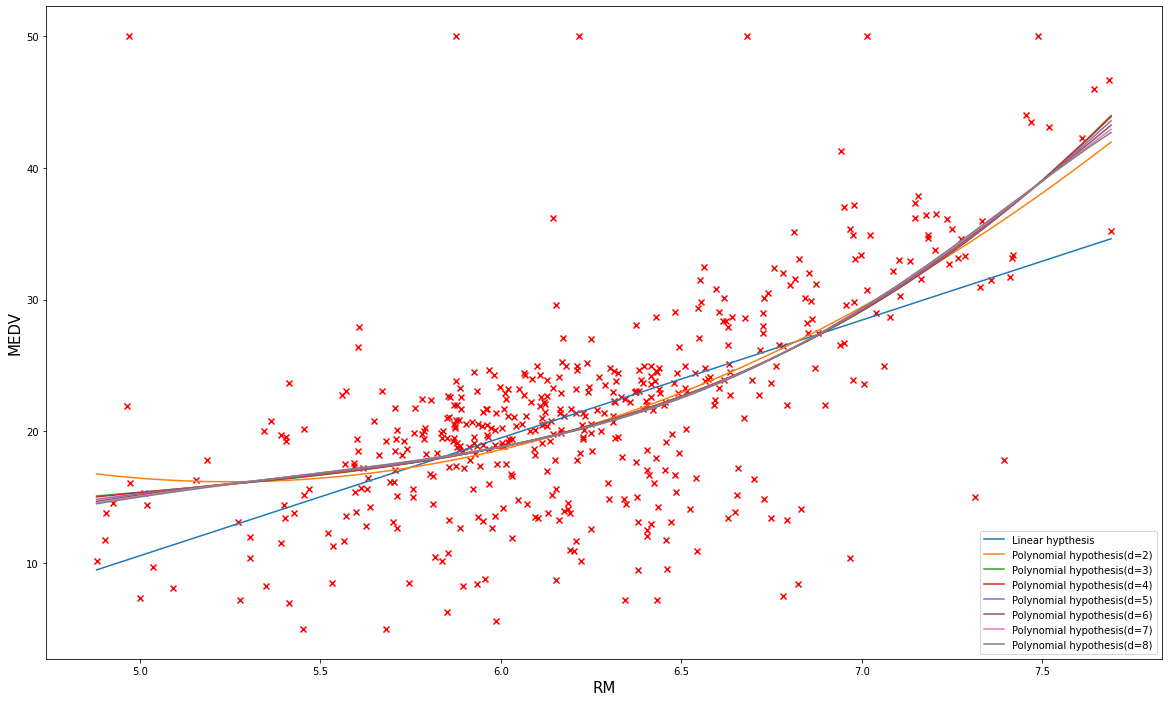

In [28]:
plt.figure(figsize=(20,12))
plt.scatter(boston_IQR_inliers[input_feature], boston_IQR_inliers[target], marker='x', c='r')
plt.plot(X_1, yhat_1, label='Linear hypthesis')
plt.plot(X_2, yhat_2, label='Polynomial hypothesis(d=2)')
plt.plot(X_3, yhat_3, label='Polynomial hypothesis(d=3)')
plt.plot(X_4, yhat_4, label='Polynomial hypothesis(d=4)')
plt.plot(X_5, yhat_5, label='Polynomial hypothesis(d=5)')
plt.plot(X_6, yhat_6, label='Polynomial hypothesis(d=6)')
plt.plot(X_7, yhat_7, label='Polynomial hypothesis(d=7)')
plt.plot(X_8, yhat_8, label='Polynomial hypothesis(d=8)')

plt.xlabel(input_feature, fontsize= 15)
plt.ylabel('MEDV', fontsize= 15)
plt.legend(loc = 'best')
plt.show()


# Z-score Method

 Prendo la feature, la proietto nello spazio dello z-score e assume una forma caratteristica gaussiana
 alla quale taglierò le code +- 3 $\sigma$

$$Z = \frac{x -\mu}{\sigma}$$

In [94]:
z_inliers = dataFrame[(np.abs(stats.zscore(dataFrame[input_feature])) < 3 )]
z_outliers = dataFrame[~(np.abs(stats.zscore(dataFrame[input_feature])) < 3 )]

In [95]:
print("# of inliers detected through the z-score method: {}".format(z_inliers.shape[0]))
print("# of outliers detected through the z-score method: {}".format(z_outliers.shape[0]))

# of inliers detected through the z-score method: 498
# of outliers detected through the z-score method: 8


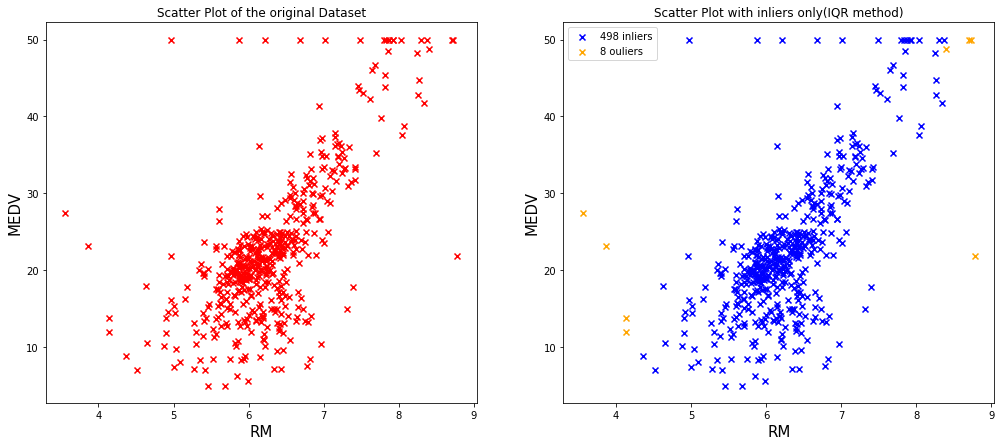

In [96]:
fig = plt.figure(figsize = (17,7))
ax1 = fig.add_subplot(121)
ax1.scatter(dataFrame[input_feature].values, dataFrame[target].values, marker = 'x', color = 'r')
ax1.set_xlabel(input_feature, fontsize= 15)
ax1.set_ylabel(target, fontsize= 15)
ax1.set_title('Scatter Plot of the original Dataset')

ax2 = fig.add_subplot(122)
ax2.scatter(z_inliers[input_feature], z_inliers[target], marker = 'x', color = 'blue', label = '{} inliers'.format(z_inliers.shape[0]))
ax2.scatter(z_outliers[input_feature], z_outliers[target], marker = 'x', color = 'orange', label = '{} ouliers'.format(z_outliers.shape[0]))
ax2.set_xlabel(input_feature, fontsize= 15)
ax2.set_ylabel(target, fontsize= 15)
ax2.set_title('Scatter Plot with inliers only(IQR method)')

plt.legend()
plt.show()


In [97]:
X_linear = polinomyal_features(z_inliers[[input_feature]], 1,input_feature);
X_poly_2 = polinomyal_features(z_inliers[[input_feature]], 2,input_feature);
X_poly_3 = polinomyal_features(z_inliers[[input_feature]], 3,input_feature);
X_poly_4 = polinomyal_features(z_inliers[[input_feature]], 4,input_feature);
X_poly_5 = polinomyal_features(z_inliers[[input_feature]], 5,input_feature);
X_poly_6 = polinomyal_features(z_inliers[[input_feature]], 6,input_feature);
X_poly_7 = polinomyal_features(z_inliers[[input_feature]], 7,input_feature);
X_poly_8 = polinomyal_features(z_inliers[[input_feature]], 8,input_feature);


In [98]:
X_linear_int = np.c_[np.ones((X_linear.shape[0],1)), X_linear]
X_poly_2_int = np.c_[np.ones((X_poly_2.shape[0],1)), X_poly_2]
X_poly_3_int = np.c_[np.ones((X_poly_3.shape[0],1)), X_poly_3]
X_poly_4_int = np.c_[np.ones((X_poly_4.shape[0],1)), X_poly_4]
X_poly_5_int = np.c_[np.ones((X_poly_5.shape[0],1)), X_poly_5]
X_poly_6_int = np.c_[np.ones((X_poly_6.shape[0],1)), X_poly_6]
X_poly_7_int = np.c_[np.ones((X_poly_7.shape[0],1)), X_poly_7]
X_poly_8_int = np.c_[np.ones((X_poly_8.shape[0],1)), X_poly_8]


In [99]:
Y = z_inliers[[target]]

In [100]:
theta_linear, _ = normal_equation(X_linear_int,Y)
theta_poly_2, _ = normal_equation(X_poly_2_int,Y)
theta_poly_3, _ = normal_equation(X_poly_3_int,Y)
theta_poly_4, _ = normal_equation(X_poly_4_int,Y)
theta_poly_5, _ = normal_equation(X_poly_5_int,Y)
theta_poly_6, _ = normal_equation(X_poly_6_int,Y)
theta_poly_7, _ = normal_equation(X_poly_7_int,Y)
theta_poly_8, _ = normal_equation(X_poly_8_int,Y)


In [101]:
X_1, yhat_1 = zip(*sorted(zip(z_inliers[input_feature],X_linear_int.dot(theta_linear))))
X_2, yhat_2 = zip(*sorted(zip(z_inliers[input_feature],X_poly_2_int.dot(theta_poly_2))))
X_3, yhat_3 = zip(*sorted(zip(z_inliers[input_feature],X_poly_3_int.dot(theta_poly_3))))
X_4, yhat_4 = zip(*sorted(zip(z_inliers[input_feature],X_poly_4_int.dot(theta_poly_4))))
X_5, yhat_5 = zip(*sorted(zip(z_inliers[input_feature],X_poly_5_int.dot(theta_poly_5))))
X_6, yhat_6 = zip(*sorted(zip(z_inliers[input_feature],X_poly_6_int.dot(theta_poly_6))))
X_7, yhat_7 = zip(*sorted(zip(z_inliers[input_feature],X_poly_7_int.dot(theta_poly_7))))
X_8, yhat_8 = zip(*sorted(zip(z_inliers[input_feature],X_poly_8_int.dot(theta_poly_8))))

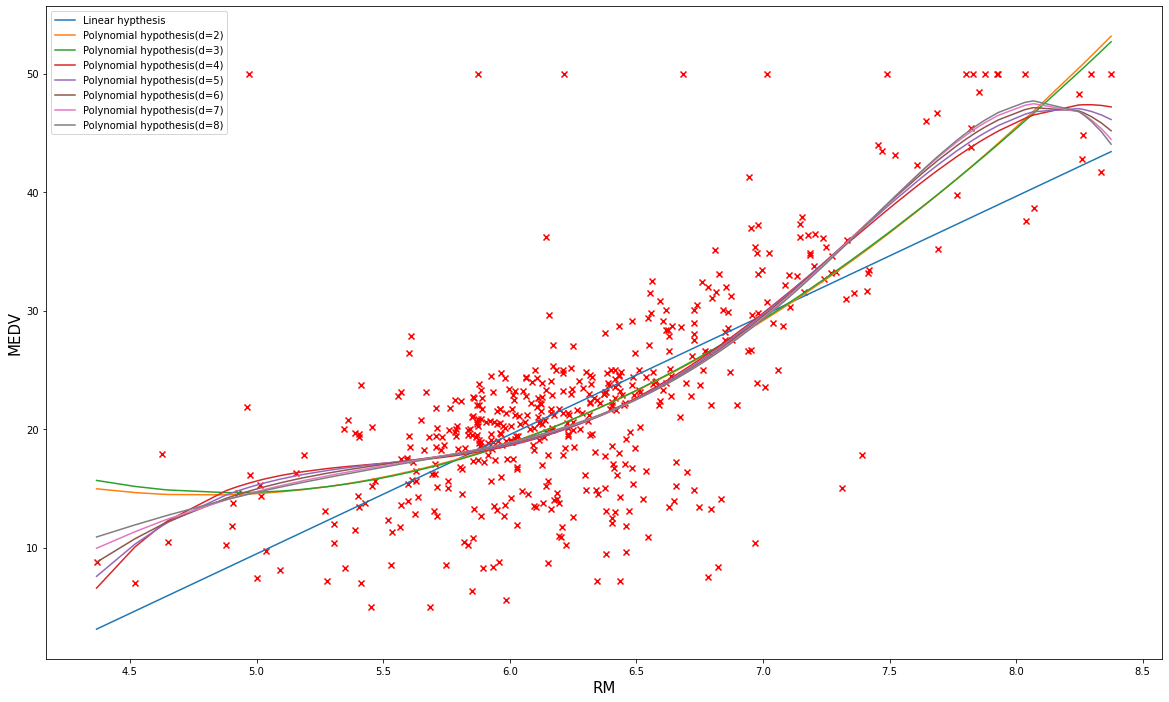

In [102]:
plt.figure(figsize=(20,12))
plt.scatter(z_inliers[input_feature], z_inliers[target], marker='x', c='r')
plt.plot(X_1, yhat_1, label='Linear hypthesis')
plt.plot(X_2, yhat_2, label='Polynomial hypothesis(d=2)')
plt.plot(X_3, yhat_3, label='Polynomial hypothesis(d=3)')
plt.plot(X_4, yhat_4, label='Polynomial hypothesis(d=4)')
plt.plot(X_5, yhat_5, label='Polynomial hypothesis(d=5)')
plt.plot(X_6, yhat_6, label='Polynomial hypothesis(d=6)')
plt.plot(X_7, yhat_7, label='Polynomial hypothesis(d=7)')
plt.plot(X_8, yhat_8, label='Polynomial hypothesis(d=8)')

plt.xlabel(input_feature, fontsize= 15)
plt.ylabel('MEDV', fontsize= 15)
plt.legend(loc = 'best')
plt.show()
